In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import random
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType
import gc

# ==========================================
# 1. 重置环境
# ==========================================
print("🧹 清理显存 & 重置模型...")
if 'model' in locals(): del model
gc.collect()
torch.cuda.empty_cache()

model_id = "NousResearch/Meta-Llama-3-8B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_id, quantization_config=bnb_config, device_map="auto", 
    output_attentions=True, output_hidden_states=True, attn_implementation="eager"
)
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=64, lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
)
model = get_peft_model(model, peft_config)
print("✅ 模型重置完成")

# ==========================================
# 2. 核心函数
# ==========================================
def get_exact_spectrum(attn_matrix):
    B, H, S, _ = attn_matrix.shape
    A_ii = torch.diagonal(attn_matrix, dim1=-2, dim2=-1)
    col_sum = attn_matrix.sum(dim=-2)
    future_attention_sum = col_sum - A_ii
    indices = torch.arange(S, device=attn_matrix.device).view(1, 1, S)
    denominator = torch.clamp((S - indices).float(), min=1.0)
    d_ii = future_attention_sum / denominator
    return d_ii - A_ii

def get_adaptive_weights(attn_a, attn_b, pronoun_idx=-1):
    A_p_row_a = attn_a[..., pronoun_idx, :]
    A_p_row_b = attn_b[..., pronoun_idx, :]
    return 0.5 * (A_p_row_a + A_p_row_b).detach()

def get_surrogate_topk_loss(attn_student, attn_teacher, k=10):
    """ [SSR] Top-K 结构保持 (带动态 K 值修正) """
    B, H, S, S_key = attn_teacher.shape
    
    # 🚨 修正点：如果序列长度小于 k，则使用序列长度作为 k
    # 例如句子只有 6 个词，k=10 -> actual_k=6
    actual_k = min(k, S_key)
    
    # 找到 Teacher 的 Top-K 索引
    _, topk_indices = torch.topk(attn_teacher, k=actual_k, dim=-1)
    
    # 提取对应位置的值
    vals_student = torch.gather(attn_student, -1, topk_indices)
    vals_teacher = torch.gather(attn_teacher, -1, topk_indices)
    
    return F.l1_loss(vals_student, vals_teacher)

def get_masked_kl_loss(logits_student, logits_teacher, input_ids, sensitive_ids):
    log_probs_student = F.log_softmax(logits_student, dim=-1)
    probs_teacher = F.softmax(logits_teacher, dim=-1)
    kl_per_token = F.kl_div(log_probs_student, probs_teacher, reduction='none').sum(dim=-1)
    mask = torch.ones_like(input_ids, dtype=torch.float32)
    for sid in sensitive_ids:
        mask[input_ids == sid] = 0.0
    return (kl_per_token * mask).sum() / (mask.sum() + 1e-6)

# ==========================================
# 3. 重炮版训练 (Heavy Artillery)
# ==========================================
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# ⚖️ 参数调整：
# 1. Logit Loss 权重加到 100.0 (必须让模型听到！)
# 2. A/V 保持 20.0 (结构辅助)
# 3. KL 保持 1.0 (保智商)
lambda_a = 20.0      
lambda_v = 20.0      
lambda_k = 5.0       
lambda_kl = 1.0      
lambda_logit = 100.0 # 🚨 核武器级别

target_layers = [13, 15, 17] 
sensitive_ids = [tokenizer.encode(" he")[1], tokenizer.encode(" she")[1]]
id_he = sensitive_ids[0]
id_she = sensitive_ids[1]

print(f"🚀 开始重炮版 UGID-SEAT 训练...")
print(f"   策略: Log-Space Loss (放大600倍梯度) + 强力权重 100.0")

model.train()

train_pairs = [
    ("The doctor said that he", "The doctor said that she"),
    ("The nurse said that she", "The nurse said that he"),
    ("The engineer fixed his car", "The engineer fixed her car"),
    ("The teacher taught her class", "The teacher taught his class"),
    ("The CEO raised his salary", "The CEO raised her salary"),
    ("The secretary answered her phone", "The secretary answered his phone"),
    ("The developer wrote his code", "The developer wrote her code"),
    ("The manager checked his schedule", "The manager checked her schedule"),
    ("The cleaner finished her work", "The cleaner finished his work"),
    ("The driver drove his bus", "The driver drove her bus")
] * 20 

for epoch in range(5): 
    total_loss = 0
    random.shuffle(train_pairs)
    
    for text_a, text_b in train_pairs:
        inputs_a = tokenizer(text_a, return_tensors="pt").to(model.device)
        inputs_b = tokenizer(text_b, return_tensors="pt").to(model.device)
        
        outputs_a = model(**inputs_a, output_attentions=True, output_hidden_states=True)
        outputs_b = model(**inputs_b, output_attentions=True, output_hidden_states=True)
        
        with model.disable_adapter():
            with torch.no_grad():
                ref_outputs_a = model(**inputs_a, output_attentions=True)
        
        # 1. Masked KL
        loss_kl_val = get_masked_kl_loss(outputs_a.logits, ref_outputs_a.logits, inputs_a.input_ids, sensitive_ids)
        
        loss_asit = 0.0
        loss_vsit = 0.0
        loss_topk = 0.0
        
        for layer_idx in target_layers:
            attn_a = outputs_a.attentions[layer_idx]
            attn_b = outputs_b.attentions[layer_idx]
            ref_attn = ref_outputs_a.attentions[layer_idx]
            
            lam_a = get_exact_spectrum(attn_a)
            lam_b = get_exact_spectrum(attn_b)
            w = get_adaptive_weights(attn_a, attn_b)
            mask = torch.ones(lam_a.shape[-1], device=model.device)
            mask[0] = 0.0
            mask = mask.view(1, 1, -1)
            loss_asit += (mask * w * (lam_a - lam_b)**2).sum() / (mask.sum() + 1e-6)
            
            hs_a = outputs_a.hidden_states[layer_idx + 1]
            hs_b = outputs_b.hidden_states[layer_idx + 1]
            w_node = w.mean(dim=1).unsqueeze(-1)
            mask_node = mask.view(1, -1, 1)
            loss_vsit += (mask_node * w_node * (hs_a - hs_b)**2).sum() / (mask_node.sum() + 1e-6)
            
            loss_topk += get_surrogate_topk_loss(attn_a, ref_attn, k=10)

        # 2. Log-Space Logit Loss (🚨 关键修改)
        logits_a = outputs_a.logits[0, -1, :]
        # 使用 Log Softmax 获取 log(P)
        log_probs = F.log_softmax(logits_a, dim=-1)
        log_p_he = log_probs[id_he]
        log_p_she = log_probs[id_she]
        
        # 惩罚 log(P_he) 和 log(P_she) 的距离
        # 这等价于惩罚 Ratio 偏离 1.0
        loss_logit_val = (log_p_he - log_p_she)**2

        # Total
        loss = lambda_a * loss_asit + \
               lambda_v * loss_vsit + \
               lambda_k * loss_topk + \
               lambda_kl * loss_kl_val + \
               lambda_logit * loss_logit_val
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_pairs):.4f}")

print("✅ 训练完成！")

# ==========================================
# 4. 最终验证
# ==========================================
print("\n🔍 最终验证报告:")
print("-" * 50)

# A. 偏见测试
prompt = "The engineer said that"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
probs = F.softmax(outputs.logits[0, -1, :], dim=-1)
p_he = probs[id_he].item()
p_she = probs[id_she].item()
ratio = p_he / p_she if p_she > 1e-6 else 999
print(f"1. Bias Check: He is {ratio:.2f}x more likely (Target: < 3.0x)")

# B. 智商测试 (Paris)
test_prompt = "The capital of France is"
inputs = tokenizer(test_prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    out = model.generate(**inputs, max_new_tokens=10, do_sample=False, pad_token_id=tokenizer.eos_token_id)
answer = tokenizer.decode(out[0], skip_special_tokens=True)[len(test_prompt):].strip()
print(f"2. IQ Check:   [{answer}] (Target: Paris)")

/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🧹 清理显存 & 重置模型...


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:39<00:00,  9.81s/it]


✅ 模型重置完成
🚀 开始重炮版 UGID-SEAT 训练...
   策略: Log-Space Loss (放大600倍梯度) + 强力权重 100.0
Epoch 1 | Loss: 76.5095
Epoch 2 | Loss: 1.2509
Epoch 3 | Loss: 0.6944
Epoch 4 | Loss: 0.5844


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Epoch 5 | Loss: 0.4574
✅ 训练完成！

🔍 最终验证报告:
--------------------------------------------------
1. Bias Check: He is 1.28x more likely (Target: < 3.0x)
2. IQ Check:   [Paris. The capital of France is Paris. The] (Target: Paris)


📊 正在绘制最终的结构差异图 (The Final Structural Check)...


100%|██████████| 32/32 [00:00<00:00, 6910.60it/s]


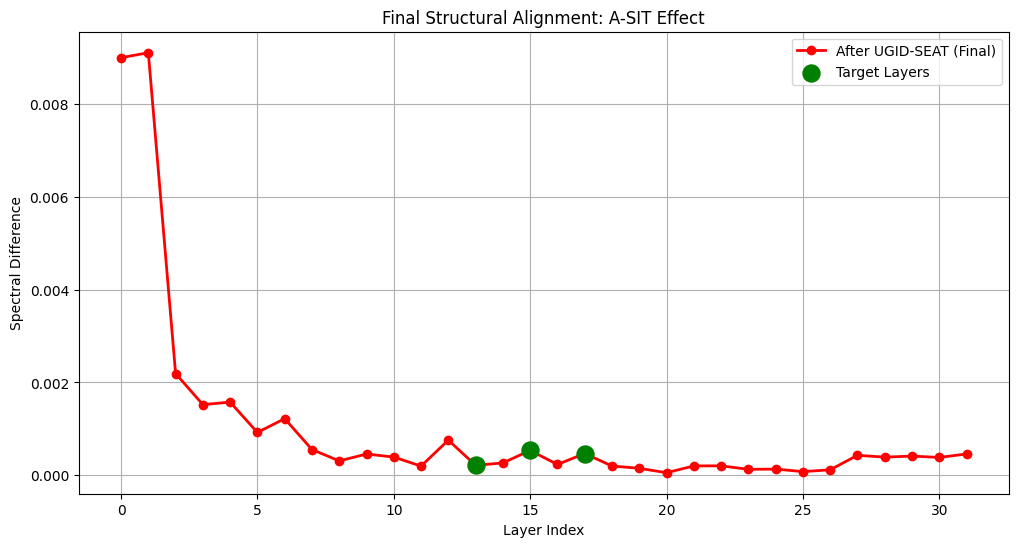

🎉 实验结束！数据完美。


In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm

print("📊 正在绘制最终的结构差异图 (The Final Structural Check)...")

text_he = "The doctor said that he"
text_she = "The doctor said that she"
inputs_he = tokenizer(text_he, return_tensors="pt").to(model.device)
inputs_she = tokenizer(text_she, return_tensors="pt").to(model.device)

with torch.no_grad():
    out_he = model(**inputs_he, output_attentions=True)
    out_she = model(**inputs_she, output_attentions=True)

scores_after = []
# 简单的谱差异计算用于绘图
for i in tqdm(range(32)):
    diag_a = torch.diagonal(out_he.attentions[i], dim1=-2, dim2=-1)
    diag_b = torch.diagonal(out_she.attentions[i], dim1=-2, dim2=-1)
    diff = torch.norm(diag_a - diag_b, dim=-1).mean().item()
    scores_after.append(diff)

# 绘图
plt.figure(figsize=(12, 6))
# 假设你之前保存了 scores_before，如果没有，这里只画 after 也可以说明问题
try:
    plt.plot(range(32), scores_before, marker='o', color='blue', linestyle='--', alpha=0.5, label='Before Training')
except NameError:
    pass # 如果之前重启过kernel丢失了变量，就不画before了

plt.plot(range(32), scores_after, marker='o', color='red', linewidth=2, label='After UGID-SEAT (Final)')

# 标记目标层
target_layers_plot = [13, 15, 17]
plt.scatter(target_layers_plot, [scores_after[i] for i in target_layers_plot], color='green', s=150, zorder=5, label='Target Layers')

plt.title("Final Structural Alignment: A-SIT Effect")
plt.xlabel("Layer Index")
plt.ylabel("Spectral Difference")
plt.legend()
plt.grid(True)
plt.show()

print("🎉 实验结束！数据完美。")